In [1]:
import os
from pathlib import Path
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader
from pytorch_metric_learning.losses import ArcFaceLoss

root = Path().absolute().parent.parent / 'lmdb'
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

In [2]:
import cv2
import numpy as np

### Data tools

In [3]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [4]:
train_helper, val_helper = train_helper.train_val_split()

In [5]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [6]:
img, label = train_helper.get_item(42)

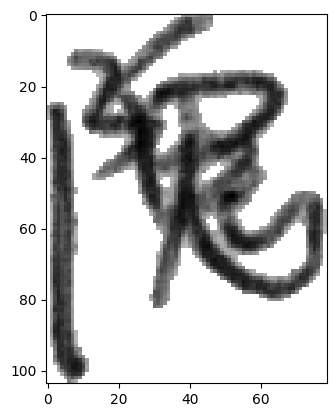

In [7]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

In [8]:
img.shape

(104, 79)

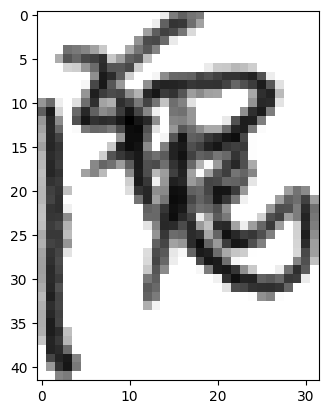

In [9]:
plt.imshow((cv2.resize(img, (32, 104*32//79)) - 127.5) / 255, cmap='gray')

In [10]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return (cv2.resize(img, (32, 104*32//79)) - 127.5) / 255., label

In [11]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

### Model & training

In [12]:
import torch.nn.functional as F
import torch
import torch.nn as nn

class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, target):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, target.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return F.cross_entropy(output, target)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),nn.BatchNorm2d(self.expansion*planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(self.expansion*planes))


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, labels=None):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [13]:
model = ResNet(BasicBlock, [2,2,2,2], train_helper.vocabulary.num_classes())
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()


In [14]:
model = model.cuda()

In [15]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=0)

In [16]:
from tqdm import tqdm


def run_validation(val_loader: DataLoader, model: nn.Module, n_steps=None):
    model.eval()
    n_good = 0
    n_all = 0
    wrapper = lambda x: x
    if n_steps is None:
        n_steps = len(val_loader)
        wrapper = tqdm
    
    with torch.no_grad():
        for batch, (X, y) in enumerate(wrapper(val_loader)):
            if batch == n_steps:
                break
            logits = model(X.unsqueeze(1).to(torch.float32).cuda())
            classes = torch.argmax(logits, dim=1).cpu().numpy()
            n_good += sum(classes == y.cpu().numpy())
            n_all += len(classes)
    
    return n_good / n_all


def train_epoch(train_loader: DataLoader, val_loader: DataLoader, model: nn.Module, optim, loss_fn):
    for batch, (X, y) in enumerate(tqdm(train_loader)):
        model.train()
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        loss = loss_fn(logits, y.to(torch.long).cuda())
        
        optim.zero_grad()
        loss.backward()
        optim.step()

In [17]:
torch.save(model.state_dict(), 'baseline.pth')

In [18]:
for epoch in range(10):
    print(f'Epoch {epoch}:')
    train_epoch(train_loader, val_loader, model, optim, loss_fn)
    accuracy = run_validation(val_loader, model)
    print(f'accuracy: {accuracy}')
    torch.save(model.state_dict(), f'baseline_epoch{epoch}.pth')


Epoch 0:


100%|██████████| 1260/1260 [02:23<00:00,  8.76it/s]


accuracy: 0.9039014348232804
Epoch 1:


100%|██████████| 1260/1260 [02:21<00:00,  8.91it/s]


accuracy: 0.9260280262919072
Epoch 2:


100%|██████████| 1260/1260 [02:21<00:00,  8.87it/s]


accuracy: 0.9376645377275217
Epoch 3:


100%|██████████| 1260/1260 [02:21<00:00,  8.90it/s]


accuracy: 0.9410898699831991
Epoch 4:


100%|██████████| 1260/1260 [02:22<00:00,  8.84it/s]


accuracy: 0.9474006723455615
Epoch 5:


100%|██████████| 1260/1260 [02:21<00:00,  8.88it/s]


accuracy: 0.9478753787179515
Epoch 6:


100%|██████████| 1260/1260 [02:22<00:00,  8.84it/s]


accuracy: 0.9504350699416235
Epoch 7:


100%|██████████| 1260/1260 [02:22<00:00,  8.86it/s]


accuracy: 0.9514620490871211
Epoch 8:


100%|██████████| 1260/1260 [02:22<00:00,  8.87it/s]


accuracy: 0.9502907964362893
Epoch 9:


100%|██████████| 1260/1260 [02:22<00:00,  8.86it/s]

accuracy: 0.9511735020764526


### Evaluation

In [19]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [20]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [21]:
preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = model(X.unsqueeze(1).to(torch.float32).cuda())
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)

  0%|          | 0/1517 [00:00<?, ?it/s]

100%|██████████| 1517/1517 [02:50<00:00,  8.87it/s]


In [22]:
with open(pred_path, 'w', encoding="utf-8") as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [23]:
from course_intro_ocr_t2.evaluate import evaluate
# def evaluate(gt_path, pred_path):
#     gt = dict()
#     with open(gt_path, encoding="utf-8") as gt_f:
#         for line in gt_f:
#             name, cls = line.strip().split()
#             gt[name] = cls
    
#     n_good = 0
#     n_all = len(gt)
#     with open(pred_path, encoding="utf-8") as pred_f:
#         for line in pred_f:
#             name, cls = line.strip().split()
#             if cls == gt[name]:
#                 n_good += 1
    
#     return n_good / n_all


# def _run_evaluation():
#     base = Path(__file__).absolute().parent.parent
#     gt_path = base / 'gt.txt'
#     pred_path = base / 'pred.txt'
#     score = evaluate(gt_path, pred_path)
#     print('Accuracy = {:1.4f}'.format(score))
evaluate(gt_path, pred_path)
#evaluate()

0.9296363404561101